IMPORT

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import dask.dataframe as dd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor, Pool
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === 0. Utility: log1p inverse ===
def inverse_log1p(arr):
    return np.expm1(arr)

LOAD DATA (read)

In [ ]:
url1 = 'https://drive.google.com/file/d/1zVQHDL976rLTZF_3o5JvaO-A7JIORhhe/view?usp=drive_link'
url2 = 'https://drive.google.com/file/d/1Tj4dA0ohDMSOolvlp0Lw3Zah3Pdt9xv1/view?usp=drive_link'

# Mengambil ID file dari tautan
file1_id = url1.split('/')[-2]
file2_id = url2.split('/')[-2]

# Membuat tautan langsung ke file CSV
download_url1 = 'https://drive.google.com/uc?id=' + file1_id
download_url2 = 'https://drive.google.com/uc?id=' + file2_id

# Membaca file CSV dari tautan
df_train = pd.read_csv(download_url1)
df_test = pd.read_csv(download_url2)


In [ ]:
df_train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900


In [ ]:
df_test

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
125685,314218,Mercedes-Benz,GL-Class GL 450 4MATIC,2014,83315,Gasoline,362.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Black,None reported,Yes
125686,314219,Audi,Q7 55 Prestige,2019,29336,Gasoline,3.0 Liter Turbo,Automatic,White,Black,None reported,NaN
125687,314220,Audi,A6 3.0T Premium Plus,2012,77634,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
125688,314221,Audi,Q7 3.0T Premium,2012,112000,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes


**PREPROCESSING DATA**
- Duplicate data
- missing value

In [ ]:
print(df_train.dtypes)
print(df_train.dtypes)

id               int64
brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object
id               int64
brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object


In [ ]:
df_train.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [ ]:
print(f"Train data : {df_train.shape}")
print(f" Test data : {df_test.shape}")

Train data : (188533, 13)
 Test data : (125690, 12)


In [ ]:
# check for duplicate data
print(f"Train data : {df_train.duplicated().sum()}")
print(f" Test data : {df_test.duplicated().sum()}")

Train data : 0
 Test data : 0


In [ ]:
# Check for missing values
missing_values_train = df_train.isnull().sum()
print("Missing values in training data:\n", missing_values_train)

missing_values_test = df_test.isnull().sum()
print("\nMissing values in test data:\n", missing_values_test)

Missing values in training data:
 id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

Missing values in test data:
 id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64


In [ ]:
# Handling missing values with median for numerical and mode for categorical features
for col in ['fuel_type', 'accident', 'clean_title']:
    if df_train[col].dtype == 'object' or df_train[col].dtype == 'category':
        mode_value = df_train[col].mode()[0]
        df_train[col].fillna(mode_value, inplace=True)
        if col in df_test.columns:
            df_test[col].fillna(mode_value, inplace=True)
    else:
        median_value = df_train[col].median()
        df_train[col].fillna(median_value, inplace=True)
        if col in df_test.columns:
            df_test[col].fillna(median_value, inplace=True)

print("Missing values in training data after handling:\n", df_train.isnull().sum())
print("\nMissing values in test data after handling:\n", df_test.isnull().sum())

/tmp/ipython-input-387536887.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[col].fillna(mode_value, inplace=True)
/tmp/ipython-input-387536887.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

Missing values in training data after handling:
 id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

Missing values in test data after handling:
 id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64


**EDA :**
- cek skewness target
- feature engineering

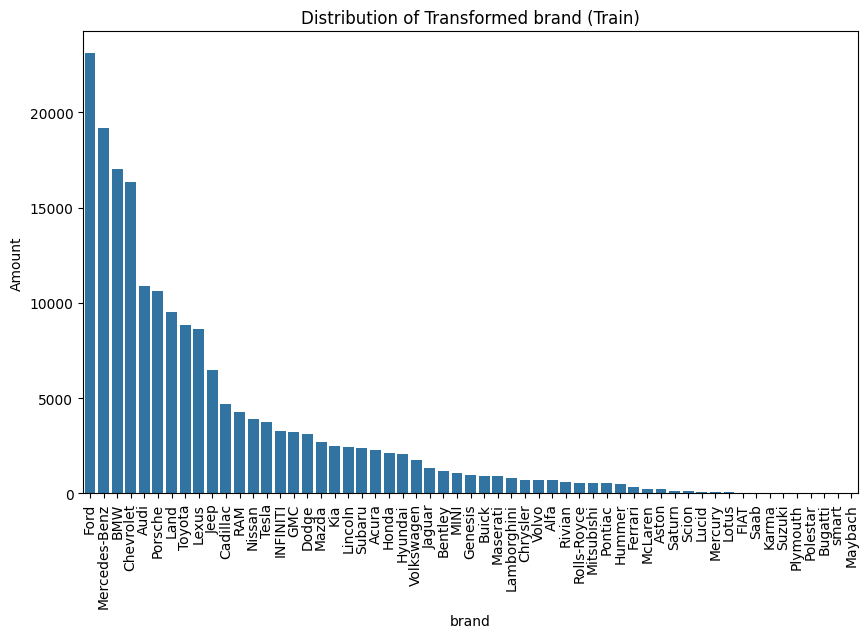

brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Chrysler           727
Volvo              723
Alfa               682
Rivian             590
Rolls-Royce        561
Mitsubishi         551
Pontiac            538
Hummer             520
Ferrari            359
McLaren            243
Aston              238
Satur

In [ ]:
# Count the number of occurrences of each brand
# print(f"Train data : {df_train['brand'].skew()}")
brand_counts = df_train['brand'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=brand_counts.index, y=brand_counts.values)
plt.title('Distribution of Transformed brand (Train)')
plt.xlabel('brand')
plt.ylabel('Amount')
plt.xticks(rotation=90)

plt.show()

print(brand_counts)

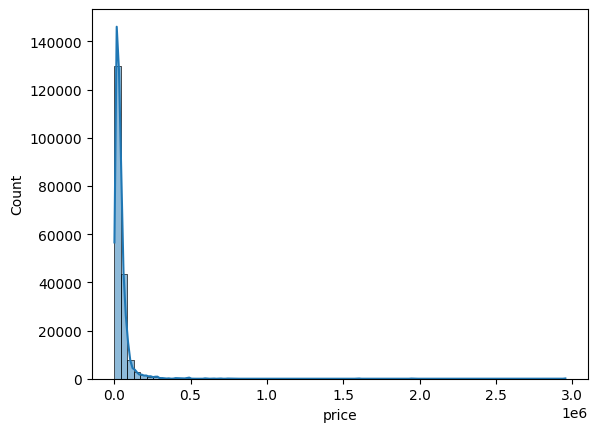

In [ ]:
sns.histplot(df_train['price'], bins=70, kde=True)
plt.show()

In [ ]:
# categorical_features = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col']
# binary_features = ['accident', 'clean_title']

# # Label Encoding for binary features
# for feature in binary_features:
#     le = LabelEncoder()
#     df_train[feature + '_encoded'] = le.fit_transform(df_train[feature].fillna('None reported'))
#     df_test[feature + '_encoded'] = le.transform(df_test[feature].fillna('None reported'))

# def split_engine(df):
#     df['horsepower'] = df['engine'].str.extract(r'(\d+)HP').astype(float)
#     df['engine_size'] = df['engine'].str.extract(r'(\d\.\d+)L').astype(float)
#     return df

# df_train = split_engine(df_train)
# df_test = split_engine(df_test)

# # Drop columns that are not needed
# df_train = df_train.drop(columns=['engine'])
# df_test = df_test.drop(columns=['engine'])

In [ ]:
# numerical_features = ['model_year', 'milage', 'horsepower', 'engine_size',
#                       'accident_encoded', 'clean_title_encoded']

# # Handle missing values and data type optimization
# df_train[numerical_features] = df_train[numerical_features].fillna(0).astype('float32')
# df_test[numerical_features] = df_test[numerical_features].fillna(0).astype('float32')

# # Column verification before preprocessing
# print("\nColumns in df_train before preprocessing:")
# print(df_train.columns.tolist())


SPLIT DATA

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df_train.drop('price', axis=1)
y = df_train['price']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (160253, 12)
X_val shape: (28280, 12)
y_train shape: (160253,)
y_val shape: (28280,)


LANJUT PREPROCESSING
- LOG TRANSFORM
- Encoding
- Scalling

y train : 20.324738957779985
y val : 19.67822195299431


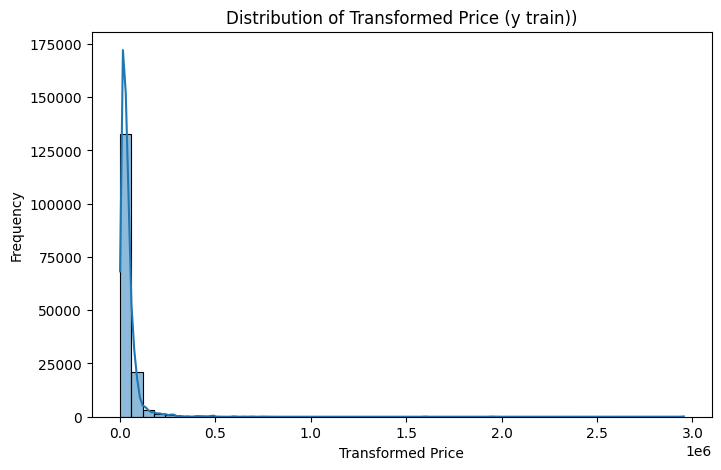

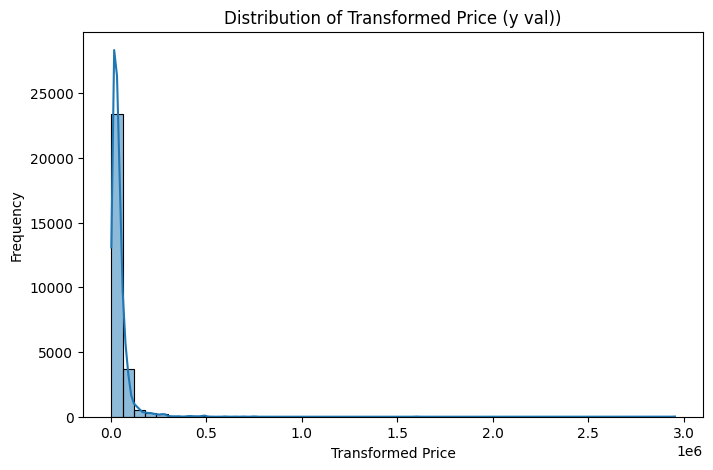

y train (before log transform): 20.324738957779985
y val (before log transform): 19.67822195299431


In [ ]:
# cek skewness target
print(f"y train : {y_train.skew()}")
print(f"y val : {y_val.skew()}")

plt.figure(figsize=(8, 5))
sns.histplot(y_train, kde=True, bins=50)
plt.title('Distribution of Transformed Price (y train))')
plt.xlabel('Transformed Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(y_val, kde=True, bins=50)
plt.title('Distribution of Transformed Price (y val))')
plt.xlabel('Transformed Price')
plt.ylabel('Frequency')
plt.show()

print(f"y train (before log transform): {y_train.skew()}")
print(f"y val (before log transform): {y_val.skew()}")

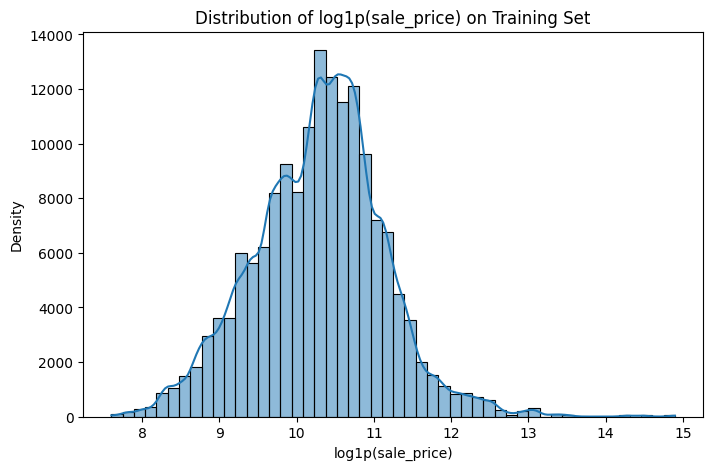

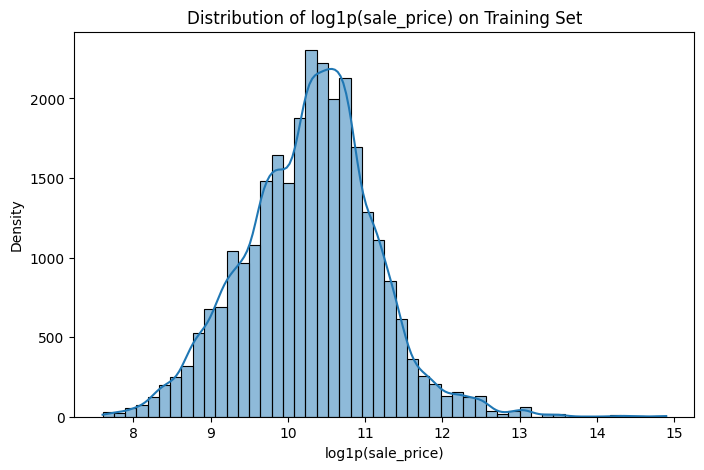

Skewness of original y_train: 20.324738957779985
Skewness of original y_val: 19.67822195299431
Skewness of log-transformed y_train: 0.10982354935807598
Skewness of log-transformed y_train: 0.09692811720425586


In [ ]:
# Log transform
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

plt.figure(figsize=(8, 5))
# sns.histplot(y_train_log, bins=50, density=True, alpha=0.7)
sns.histplot(y_train_log, kde=True, bins=50)
plt.title("Distribution of log1p(sale_price) on Training Set")
plt.xlabel("log1p(sale_price)")
plt.ylabel("Density")
plt.show()


plt.figure(figsize=(8, 5))
# sns.histplot(y_train_log, bins=50, density=True, alpha=0.7)
sns.histplot(y_val_log, kde=True, bins=50)
plt.title("Distribution of log1p(sale_price) on Training Set")
plt.xlabel("log1p(sale_price)")
plt.ylabel("Density")
plt.show()


print("Skewness of original y_train:", y_train.skew())
print("Skewness of original y_val:", y_val.skew())
print("Skewness of log-transformed y_train:", pd.Series(y_train_log).skew())
print("Skewness of log-transformed y_train:", pd.Series(y_val_log).skew())


In [ ]:
# Identify binary, numeric & categorical columns
categorical_features = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col']
binary_features = ['accident', 'clean_title']
numerical_features = ['model_year', 'milage', 'horsepower', 'engine_size',
                      'accident_encoded', 'clean_title_encoded']

In [ ]:
# Quick check
print("Categorical cardinalities:")
for col in categorical_features:
    nunique = X_train[col].nunique()
    print(f"  {col}: {nunique} unique values")
    # If cardinality is huge (say > 30), consider target encoding or frequency encoding instead.

Categorical cardinalities:
  brand: 57 unique values
  model: 1897 unique values
  fuel_type: 7 unique values
  transmission: 52 unique values
  ext_col: 319 unique values
  int_col: 156 unique values


In [ ]:
# # Label Encoding for binary features
# for feature in binary_features:
#     le = LabelEncoder()
#     df_train[feature + '_encoded'] = le.fit_transform(df_train[feature].fillna('None reported'))
#     df_test[feature + '_encoded'] = le.transform(df_test[feature].fillna('None reported'))

# def split_engine(df):
#     df['horsepower'] = df['engine'].str.extract(r'(\d+)HP').astype(float)
#     df['engine_size'] = df['engine'].str.extract(r'(\d\.\d+)L').astype(float)
#     return df

# df_train = split_engine(df_train)
# df_test = split_engine(df_test)

# # Drop columns that are not needed
# df_train = df_train.drop(columns=['engine'])
# df_test = df_test.drop(columns=['engine'])

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='drop')

MODELING Ridge

In [ ]:
# Identify categorical columns for CatBoost (automatically handles them)
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [ ]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric="RMSE",
    random_seed=42,
    verbose=False
)

train_pool = Pool(X_train, y_train_log, cat_features=cat_features)
val_pool = Pool(X_val, y_val_log, cat_features=cat_features)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

In [ ]:
# RMSE manual (karena squared=False mungkin tidak tersedia)
y_val_log_pred = model.predict(val_pool)
y_val_pred = inverse_log1p(y_val_log_pred)  # back to original scale

mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)

print(f"MSE : {mse_val:.4f}")
print(f"RMSE : {rmse_val:.4f}")
print(f"R2 : {r2_val:.4f}")

MSE : 4589312297.8118
RMSE : 67744.4632
R2 : 0.1524


In [ ]:
# Split-conformal calibration using folds on training portion
kf = KFold(n_splits=5, shuffle=True, random_state=42)
nonconformity = []

for train_idx, cal_idx in kf.split(X_train):
    X_tr, X_cal = X_train.iloc[train_idx], X_train.iloc[cal_idx]
    y_tr, y_cal = y_train.iloc[train_idx], y_train.iloc[cal_idx]
    y_tr_log = np.log1p(y_tr)

    pool_tr = Pool(X_tr, y_tr_log, cat_features=cat_features)
    pool_cal = Pool(X_cal, cat_features=cat_features)

    fold_model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        random_seed=42,
        verbose=False
    )
    fold_model.fit(pool_tr, early_stopping_rounds=50, eval_set=pool_cal)

    y_cal_log_pred = fold_model.predict(pool_cal)
    y_cal_pred = inverse_log1p(y_cal_log_pred)
    residuals = np.abs(y_cal.values - y_cal_pred)
    nonconformity.extend(residuals.tolist())

coverage = 0.9  # bisa ubah ke 0.95 dll.
q = np.quantile(nonconformity, coverage)
print(f"Conformal half-width q (coverage={coverage}): {q:.4f}")

Conformal half-width q (coverage=0.9): 30490.2829


In [ ]:
# Retrain on full train+val ===
X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)
y_full_log = np.log1p(y_full)
full_pool = Pool(X_full, y_full_log, cat_features=cat_features)

model_final = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=False
)
model_final.fit(full_pool, early_stopping_rounds=50)

In [ ]:
# Assume df_test has same raw features (no sale_price if blind test)
X_test = df_test.copy()
# If test has sale_price and you want evaluation:
has_label = "price" in df_test.columns
if has_label:
    y_test = df_test["price"]

In [ ]:
test_pool = Pool(X_test, cat_features=cat_features)
y_test_log_pred = model_final.predict(test_pool)
y_test_pred = inverse_log1p(y_test_log_pred)

In [ ]:
# Interval: [pred - q, pred + q] clipped at minimum zero
# lower = np.maximum(y_test_pred - q, 0)
# upper = y_test_pred + q


In [ ]:
submission = pd.DataFrame({"id" : df_test["id"], "price" : y_test_pred})
submission.to_csv("submissionCarPrize_Catboost.csv", index=False)

if has_label:
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    r2_test = r2_score(y_test, y_test_pred)
    print(f"[Test] RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

# Show some predictions with intervals
print(submission[["id", "price"]].head())

       id         price
0  188533  16313.494422
1  188534  61919.163170
2  188535  49816.503443
3  188536  24804.612547
4  188537  29154.239660


In [ ]:
data_save = "/content/drive/MyDrive/PORTO/KAGGLE_COMPETITION/REGRESSION/House_Price_Prediction/notebook/Submission"

# kalau mau simpan
submission.to_csv(f"{data_save}/submissionCarPrize_Catboost.csv", index=False)

print("Submission sample:")
print(submission.head())

Submission sample:
       id         price
0  188533  16313.494422
1  188534  61919.163170
2  188535  49816.503443
3  188536  24804.612547
4  188537  29154.239660
